### Triple Barrier Methods

In this section, I introduce an alternative labeling technique that you may not find in academic papers. If readers are investment professionals, they might agree that this method is more rational. The author, Lopez de Prado, refers to it as the Triple Barrier method because observations are labeled based on which barrier is reached first among three.

First, two horizontal barriers and one vertical barrier are established. The two horizontal barriers are defined by profit-taking and stop-loss limits, which are dynamic functions based on estimated volatility. The third barrier is defined by the number of bars passed since a position was taken (the expiration limit).

- If the upper barrier is reached first, the observation is labeled as 1.
- If the lower barrier is reached first, it is labeled as -1.
- If the vertical barrier is reached first, there are two choices: label it based on the sign of the profit or label it as 0. While the author prefers the former, it's worth experimenting to see if labeling as 0 works better for your specific scenario.

This method allows for a more nuanced approach to labeling that considers the dynamics of market movements, providing a more robust framework for evaluating trading strategies.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ['http_proxy'] = 'http://localhost:4080/'
os.environ['https_proxy'] = 'http://localhost:4080/'


start_date = '2000-01-01'
end_date = '2024-04-27'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

data.index = data.index.date
print(data.head(5))

[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
2000-01-03  0.844004  0.999442  1.004464  0.907924  0.936384  535796800
2000-01-04  0.772846  0.915179  0.987723  0.903460  0.966518  512377600
2000-01-05  0.784155  0.928571  0.987165  0.919643  0.926339  778321600
2000-01-06  0.716296  0.848214  0.955357  0.848214  0.947545  767972800
2000-01-07  0.750226  0.888393  0.901786  0.852679  0.861607  460734400


In [2]:
from quant_free.finml.labeling.labeling import *
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Adj Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

2000-01-03    2000-01-10
2000-01-04    2000-01-11
2000-01-05    2000-01-12
2000-01-06    2000-01-13
2000-01-07    2000-01-14
dtype: object

The output of this function is a `pandas.DataFrame` that includes timestamps for when each barrier is reached. As previously mentioned, this technique considers the possibility of each of the three barriers being inactive. Let's represent the barrier settings as three values: \([pt, sl, t1]\), where 0 indicates the barrier is inactive and 1 indicates it is active. Here are the eight possible settings:

**Three Useful Settings**

| Profit Taking | Stopping Loss | Vertical Barrier | Description                                                                                                                        |
|:-------------:|:-------------:|:----------------:|:-----------------------------------------------------------------------------------------------------------------------------------|
|       1       |       1       |        1         | Standard setting that defines exit conditions for all three barriers. It allows for profit realization while considering maximum loss tolerance and holding period constraints. |
|       0       |       1       |        1         | Only the stop-loss and vertical barrier are active. If not stopped out, the aim is to exit after a certain number of bars.         |
|       1       |       1       |        0         | The goal is to realize profits without stop-loss; this implies holding the position indefinitely, which may be unrealistic.         |

**Three Less Realistic Settings**

| Profit Taking | Stopping Loss | Vertical Barrier | Description                                                                                                                        |
|:-------------:|:-------------:|:----------------:|:-----------------------------------------------------------------------------------------------------------------------------------|
|       0       |       0       |        1         | Similar to fixed horizon methods. It may still be useful for applying to volume, dollar, or information-driven bars or when updating multiple predictions within a fixed period. |
|       1       |       0       |        1         | Hold the position until a profit is realized or the maximum holding period expires, disregarding intermediate unrealized losses.   |
|       1       |       0       |        0         | Maintain the position until a profit occurs, which could mean being stuck in a losing position for years.                        |

**Two Illogical Settings**

| Profit Taking | Stopping Loss | Vertical Barrier | Description                             |
|:-------------:|:-------------:|:----------------:|:----------------------------------------|
|       0       |       1       |        0         | A setting without a target, simply holding until stopped out.                     |
|       0       |       0       |        0         | No barriers; the position is fixed indefinitely, and no label is generated.       |

These settings highlight the flexibility and limitations of the Triple Barrier method, allowing you to tailor your approach based on your investment strategy and market conditions.

### Learning Side and Size

In this section, we discuss how to label data so that machine learning algorithms can learn the direction and size of bets. Typically, when there is no base model for determining the sign of a position (buy or sell), the focus tends to be on figuring out the direction of the bet. In such situations, it can be challenging to distinguish between the profit-taking barrier (upper bound) and the stop-loss barrier (lower bound) because there is no prior knowledge about the direction. 

Understanding the direction implies that either the horizontal barriers are absent or that they are symmetric. This symmetry allows the model to treat the potential for profit and loss as equal, enabling a more effective learning process regarding the size of the bets. By properly labeling the data in this context, machine learning algorithms can be trained to predict not only whether to enter a trade but also how much to stake based on the anticipated risk and return.

In practical terms, this means establishing clear labeling criteria for training data, ensuring that the model can learn to differentiate between upward and downward movements, as well as the size of each movement based on the established barriers. By doing so, the model can effectively manage both the direction and magnitude of investment decisions.

In [3]:
from quant_free.finml.features.volatility import daily_volatility

volatility = daily_volatility(data['Adj Close'], lookback = 60)

In [4]:
triple_barrier_events = get_events(
    close = data['Adj Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

/home/disk1/quant_free/quant_free/finml/labeling/labeling.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2000-01-18' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.loc[loc, 'pt'] = cum_returns[cum_returns > profit_taking[loc]].dropna().index.min()


,t1,trgt,pt,sl
2000-01-07,2000-01-11,0.016797,2,1
2000-01-10,2000-01-12,0.026415,2,1
2000-01-11,2000-01-12,0.024043,2,1
2000-01-12,2000-01-13,0.031168,2,1
2000-01-13,2000-01-19,0.050703,2,1


The `meta_labeling` function can be used to assign labels to observations in the following code. You would pass the previously created event `pandas.DataFrame` object as the first argument, and use a `pandas.Series` containing the Close price (or VWAP) as the second argument. The output will be a DataFrame containing columns for `ret`, `trgt`, and `bin`.

Here’s a sample implementation:

```python
import pandas as pd

def meta_labeling(events_df, prices):
    # Initialize lists to hold the outputs
    ret = []
    trgt = []
    bin = []

    for index, event in events_df.iterrows():
        # Extract relevant information from the event
        barrier_reached = event['barrier_reached']  # Assume this column exists
        entry_price = prices[event['entry_index']]
        
        # Calculate return based on whether the upper or lower barrier was hit
        if barrier_reached == 'upper':
            return_value = (prices[event['exit_index']] - entry_price) / entry_price
            target = 1  # Label for profit realization
        elif barrier_reached == 'lower':
            return_value = (prices[event['exit_index']] - entry_price) / entry_price
            target = -1  # Label for loss realization
        else:
            return_value = (prices[event['exit_index']] - entry_price) / entry_price
            target = 0  # Neutral label

        # Append values to the lists
        ret.append(return_value)
        trgt.append(target)
        bin.append(event['bin'])  # Assume 'bin' is a part of the event

    # Create a DataFrame from the outputs
    output_df = pd.DataFrame({
        'ret': ret,
        'trgt': trgt,
        'bin': bin
    })

    return output_df

# Usage
events_df = pd.DataFrame(...)  # Your events DataFrame
prices = pd.Series(...)  # Your price series (Close or VWAP)
labeled_data = meta_labeling(events_df, prices)

print(labeled_data)
```

This code iterates through the events DataFrame, calculates the returns based on whether the upper or lower barrier was reached, and labels the observations accordingly. The resulting DataFrame contains the return, target label, and any additional bin information.

In [5]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Adj Close']
)

In [6]:
labels.head()

,ret,trgt,bin
2000-01-07,-0.067839,0.016797,-1
2000-01-10,-0.108056,0.026415,-1
2000-01-11,-0.059973,0.024043,-1
2000-01-12,0.109677,0.031168,1
2000-01-13,0.101422,0.050703,0


In [7]:
labels['bin'].value_counts()

bin
 0    3789
-1    1363
 1     957
Name: count, dtype: int64

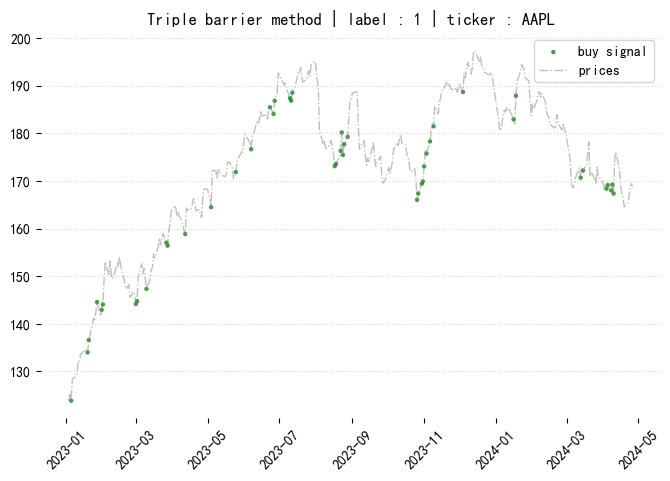

In [8]:
import datetime

start_date = datetime.date(2023, 1, 1)
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == 1][start_date:].index,
    data.loc[labels[labels['bin'] == 1].index][start_date:]['Adj Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'green',
    label = 'buy signal'
)
ax.plot(
    data[start_date:]['Adj Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | label : 1 | ticker : AAPL')
plt.show()

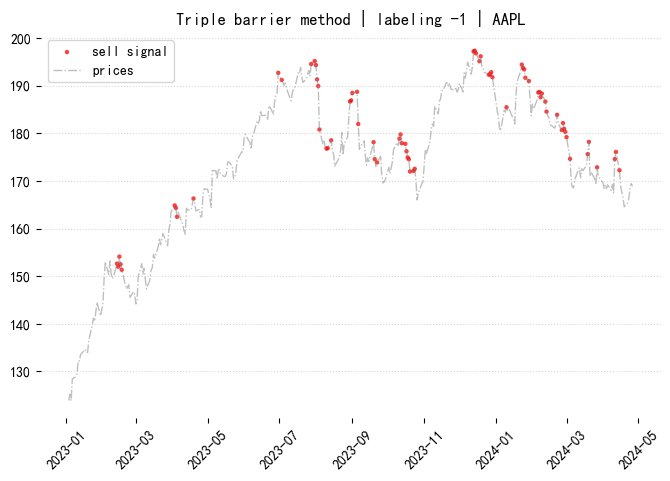

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == -1][start_date:].index,
    data.loc[labels[labels['bin'] == -1].index][start_date:]['Adj Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'red',
    label = 'sell signal'
)
ax.plot(
    data[start_date:]['Adj Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | labeling -1 | AAPL')
plt.show()

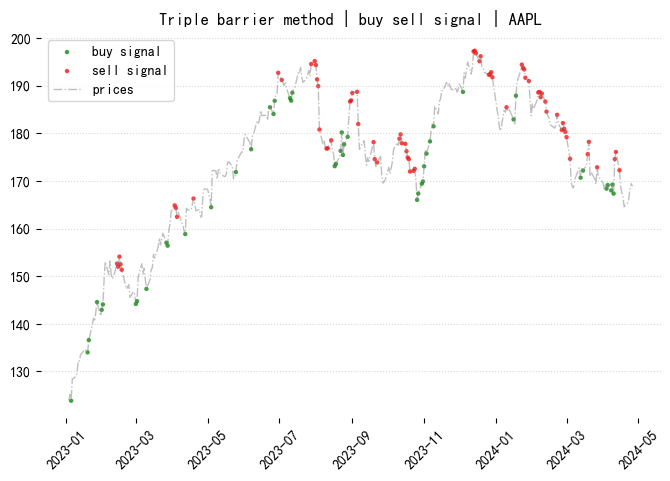

In [21]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == 1][start_date:].index,
    data.loc[labels[labels['bin'] == 1].index][start_date:]['Adj Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'green',
    label = 'buy signal'
)
ax.scatter(
    labels[labels['bin'] == -1][start_date:].index,
    data.loc[labels[labels['bin'] == -1].index][start_date:]['Adj Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'red',
    label = 'sell signal'
)
ax.plot(
    data[start_date:]['Adj Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | buy sell signal | AAPL')
plt.show()